### DOVA algorithm implementation
Before running this notebook make sure to run the data notebook to obtain the needed schedule data for the DOVA algorithm. This first cell will take a KV6 dataset with added runtimeseconds. For each row it will calculate the predicted delay according to the DOVA specification. 

In [ ]:
import numpy as np
import pandas as pd
import ast

def _ensure_list(x):
    """Parse python-list-like strings into a Python list; return None if impossible."""
    if x is None:
        return None
    if isinstance(x, float) and np.isnan(x):
        return None
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return None
        try:
            x = ast.literal_eval(s)
        except Exception:
            return None
    try:
        return list(x)
    except Exception:
        return None

def _ensure_runtime_list(run_times_seconds):
    """Return a list[float] or None."""
    rt = _ensure_list(run_times_seconds)
    if rt is None:
        return None
    out = []
    for v in rt:
        try:
            out.append(float(v))
        except Exception:
            return None
    return out

def _normalize_stop(x) -> str | None:
    """
    Ensure stopcodes match between KV6 and StopCodes column.
    - If StopCodes already contains plain numbers as strings (like your example), this is fine.
    - If it contains 'CXX:ScheduledStopPoint:68601010', this will also work.
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().strip("'").strip('"')
    if ":" in s:
        s = s.split(":")[-1]
    return s

def dova_predict_target_delay_by_stopcodes(
    current_delay: float,
    current_stop,
    target_stop,
    stop_codes,
    run_times_seconds,
    speed_factor: float = 0.9,
    clamp_min: float | None = 0.0,
) -> float:
    stops = _ensure_list(stop_codes)
    rt = _ensure_runtime_list(run_times_seconds)
    if stops is None or rt is None:
        return np.nan

    # normalize
    stops_norm = [_normalize_stop(s) for s in stops]
    cs = _normalize_stop(current_stop)
    ts = _normalize_stop(target_stop)
    if cs is None or ts is None:
        return np.nan

    # Build index map (faster and handles many rows)
    stop_to_idx = {s: i for i, s in enumerate(stops_norm) if s is not None}

    if cs not in stop_to_idx or ts not in stop_to_idx:
        return np.nan

    i = stop_to_idx[cs]
    j = stop_to_idx[ts]

    if j <= i:
        pred = float(current_delay)
        return max(clamp_min, pred) if clamp_min is not None else pred

    if j == i + 1:
        pred = float(current_delay)
        return max(clamp_min, pred) if clamp_min is not None else pred

    # slice rt[i:j] requires j <= len(rt)
    if j > len(rt) or i < 0:
        return np.nan

    planned_runtime = float(sum(rt[i:j]))

    # late-only recovery (DOVA logic)
    recovery = (1.0 - float(speed_factor)) * planned_runtime if float(current_delay) > 0 else 0.0
    pred = float(current_delay) - recovery
    return max(clamp_min, pred) if clamp_min is not None else pred

def add_dova_prediction_column(
    df: pd.DataFrame,
    speed_factor: float = 0.9,
    clamp_min: float | None = 0.0,
    out_col: str = "dova_pred_delay",
) -> pd.DataFrame:
    df = df.copy()

    # Parse once
    df["_rt_list"] = df["RunTimesSeconds"].apply(_ensure_runtime_list)
    df["_stops_list"] = df["StopCodes"].apply(_ensure_list)

    df[out_col] = df.apply(
        lambda r: dova_predict_target_delay_by_stopcodes(
            current_delay=r["current_delay"],
            current_stop=r["current_stop"],
            target_stop=r["target_stop"],
            stop_codes=r["_stops_list"],
            run_times_seconds=r["_rt_list"],
            speed_factor=speed_factor,
            clamp_min=clamp_min,
        ),
        axis=1,
    )

    df.drop(columns=["_rt_list", "_stops_list"], inplace=True)
    return df

inputdf = pd.read_csv("line002_combinations_exp_with_dova.csv")

df = add_dova_prediction_column(inputdf, speed_factor=0.9, clamp_min=0.0, out_col="dova_pred_delay")
df.to_csv("line002_predictions.csv", index=False)
df.head(20)


FileNotFoundError: [Errno 2] No such file or directory: 'line401_combinations_exp_with_dova.csv'

,Model,MAE (s),MSE (s^2),RMSE (s),NRMSE (-),R2,P90-AE (s),N
0,DOVA,67.779652,10729.680234,103.58417,0.025851,0.558783,148.0,1257204


Sanity checks:
  Mean actual delay (s):     115.2155147454192
  Mean predicted delay (s):  88.28012558025587
  Min/Max actual delay (s):  -543.0 / 3464.0
  Min/Max predicted (s):     0.0 / 3464.0


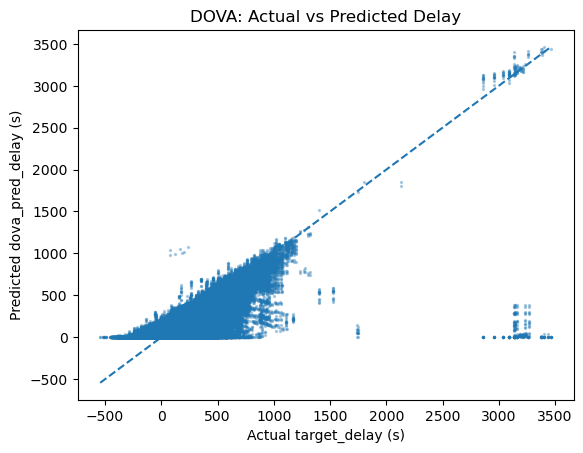

In [ ]:
# --- Evaluate DOVA predictions vs actual target_delay ---
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('line002_predictions.csv')
df = df[df["current_delay"].astype(float) >= 0].copy()

# 1) Filter valid rows
eval_df = df[df["target_delay"].notna() & df["dova_pred_delay"].notna()].copy()

y_true = eval_df["target_delay"].astype(float).to_numpy()
y_pred = eval_df["dova_pred_delay"].astype(float).to_numpy()

# 2) Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# NRMSE (normalized by range of actuals)
range_y = float(y_true.max() - y_true.min())
nrmse = (rmse / range_y) if range_y != 0 else np.nan

# P90 Absolute Error
abs_errors = np.abs(y_true - y_pred)
p90_ae = float(np.percentile(abs_errors, 90))

# 3) Results table
metrics = pd.DataFrame([{
    "Model": "DOVA",
    "MAE (s)": mae,
    "MSE (s^2)": mse,
    "RMSE (s)": rmse,
    "NRMSE (-)": nrmse,
    "R2": r2,
    "P90-AE (s)": p90_ae,
    "N": int(len(eval_df)),
}])

display(metrics)

# 4) Sanity checks
print("Sanity checks:")
print("  Mean actual delay (s):    ", float(np.mean(y_true)))
print("  Mean predicted delay (s): ", float(np.mean(y_pred)))
print("  Min/Max actual delay (s): ", float(np.min(y_true)), "/", float(np.max(y_true)))
print("  Min/Max predicted (s):    ", float(np.min(y_pred)), "/", float(np.max(y_pred)))

# 5) Quick plot: actual vs predicted
plt.figure()
plt.scatter(y_true, y_pred, s=2, alpha=0.3)
plt.xlabel("Actual target_delay (s)")
plt.ylabel("Predicted dova_pred_delay (s)")
plt.title("DOVA: Actual vs Predicted Delay")
mn = float(min(y_true.min(), y_pred.min()))
mx = float(max(y_true.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import ast

adf = pd.read_csv('line002_predictions.csv')
adf.tail(20)

,to_station,operatingday,day_type,journeynumber,current_stop,current_stop_index,current_delay,target_stop_index,target_stop,target_delay,RunTimesSeconds,dova_pred_delay
2724916,1,2025-08-11,0,335,64001860,14,-228.0,10,64111760,-73.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724917,1,2025-08-11,0,335,64001860,14,-228.0,11,64001780,-82.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724918,1,2025-08-11,0,335,64001860,14,-228.0,12,64001805,-117.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724919,1,2025-08-11,0,335,64001860,14,-228.0,13,64001820,-108.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724920,1,2025-08-11,0,335,64001860,14,-228.0,15,64001880,-302.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724921,1,2025-08-11,0,335,64001880,15,-302.0,0,64308620,29.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724922,1,2025-08-11,0,335,64001880,15,-302.0,1,64308560,55.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724923,1,2025-08-11,0,335,64001880,15,-302.0,2,64118540,97.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724924,1,2025-08-11,0,335,64001880,15,-302.0,3,64118520,76.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0
2724925,1,2025-08-11,0,335,64001880,15,-302.0,4,64118480,52.0,"[60, 0, 60, 60, 60, 60, 60, 60, 120, 60, 60, 1...",0.0


In [ ]:
# Create a new csv file with just the first five lines and some specific columns
current_df = pd.read_csv('line002_combinations_exp_with_dova.csv')
new_df = current_df.loc[:, ['current_stop', 'current_delay', 'target_stop',  'StopCodes', 'RunTimesSeconds']]
new_df_head = new_df.head(5)
new_df_head.to_csv('line002_dova_sample.csv', index=False)